# Internet traffic attack recognition (ShieldNet - multiclass)

In [21]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pandas as pd
import numpy as np
import torch
if not torch.cuda.is_available():
    quit()
else:
    print("Cuda capable device found!")
import matplotlib.pyplot as plt

Cuda capable device found!


# Get the datasets from memory

Assumption: dataset has its colums' names stripped from white spaces, no NaNs or +-Inf

In [22]:
ds_selector='.\\datasets\\kaggle DDoS Dataset\\small'

In [23]:
csv_files = []
for dirname, _, filenames in os.walk(ds_selector):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        csv_files.append(csv_file)
csv_files

['.\\datasets\\kaggle DDoS Dataset\\small\\final.csv']

In [24]:
if len(csv_files) > 1:
    df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
else:
    df=pd.read_csv(csv_files[0])
    
df.columns = df.columns.str.strip()
print("Original length of df:", len(df))

Original length of df: 1000000


## Tidy up the dataset

In [25]:
#df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 85 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1000000 non-null  int64  
 1   Flow ID            1000000 non-null  object 
 2   Src IP             1000000 non-null  object 
 3   Src Port           1000000 non-null  int64  
 4   Dst IP             1000000 non-null  object 
 5   Dst Port           1000000 non-null  int64  
 6   Protocol           1000000 non-null  int64  
 7   Timestamp          1000000 non-null  object 
 8   Flow Duration      1000000 non-null  int64  
 9   Tot Fwd Pkts       1000000 non-null  int64  
 10  Tot Bwd Pkts       1000000 non-null  int64  
 11  TotLen Fwd Pkts    1000000 non-null  float64
 12  TotLen Bwd Pkts    1000000 non-null  float64
 13  Fwd Pkt Len Max    1000000 non-null  float64
 14  Fwd Pkt Len Min    1000000 non-null  float64
 15  Fwd Pkt Len Mean   1000000 non-nu

In [26]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("After dropping NaNs, the length of df:", len(df))

After dropping NaNs, the length of df: 1000000


In [27]:
df_copy=df.copy()
df_copy.Label.value_counts()

ddos      500000
Benign    500000
Name: Label, dtype: int64

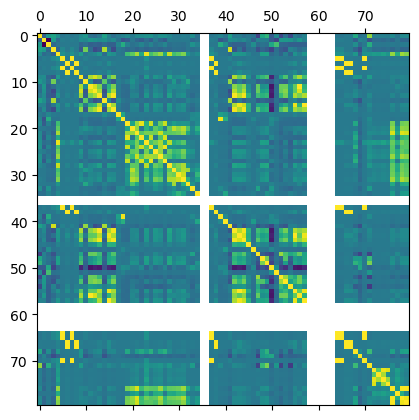

In [28]:
corr_mat=df_copy.corr()
plt.matshow(corr_mat)
plt.show()

## Getting ready for learning

In [29]:
cols=df_copy.columns.to_list()
#cols.sort()
cols

['Unnamed: 0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pk

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [31]:
df_copy.drop(['Unnamed: 0','Timestamp','Protocol','Flow ID','Src IP','Dst IP'], axis=1, inplace=True)

In [32]:
cols=df_copy.columns.to_list()
len(cols)

79

In [33]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        print('Removing column', str(col))
        df_copy.drop(col,inplace=True,axis=1)

Removing column Fwd URG Flags
Removing column Bwd URG Flags
Removing column Fwd Byts/b Avg
Removing column Fwd Pkts/b Avg
Removing column Fwd Blk Rate Avg
Removing column Bwd Byts/b Avg
Removing column Bwd Pkts/b Avg
Removing column Bwd Blk Rate Avg


In [34]:
#from sklearn.feature_selection import SelectKBest, f_classif

X=df_copy.drop(['Label'], axis=1)
Y=df_copy['Label']

#fvalue_Best = SelectKBest(f_classif, k=20)
#X_kbest = fvalue_Best.fit_transform(X, Y)

#X=X_kbest

In [35]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, shuffle=True, train_size=0.75)
del df_copy,X,Y

In [36]:
trainX.shape

(750000, 70)

In [37]:
from torch import tensor
from torch.utils.data import Dataset, DataLoader

class NetMetrics(Dataset):
    def __init__(self, X, y, onehot):
        self.x, self.y, self.onehot = X, y, onehot
        self.len=self.x.shape[0]

    def __getitem__(self,index):
        tensor_label=self.onehot[self.y.iloc[index]]
        return tensor(self.x[index], dtype=torch.float32), tensor_label
        
    def __len__(self):
        return self.len

dict_={'ddos' : torch.tensor([1,0], dtype=torch.float32),'Benign': torch.tensor([0,1],dtype=torch.float32)}
ds=NetMetrics(scaler.fit_transform(trainX), trainY, dict_)

## The model

In [38]:
class AttackNet(torch.nn.Module):
    def __init__(self):
        super(AttackNet, self).__init__()
        self.encoder=torch.nn.Sequential(
            torch.nn.Linear(70, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 20)
            )
        self.decoder=torch.nn.Sequential(
            torch.nn.Linear(20, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 70)
            )
        self.classifier=torch.nn.Sequential(
            torch.nn.Linear(20, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 2),
            torch.nn.Sigmoid(),
            torch.nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        out=self.classifier(encoded)
        return decoded, out

## Training

In [50]:
device = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device

'cuda:0'

Epoch begin:  0
Epoch begin:  1
Epoch begin:  2
Epoch begin:  3
Epoch begin:  4
Epoch begin:  5
Epoch begin:  6


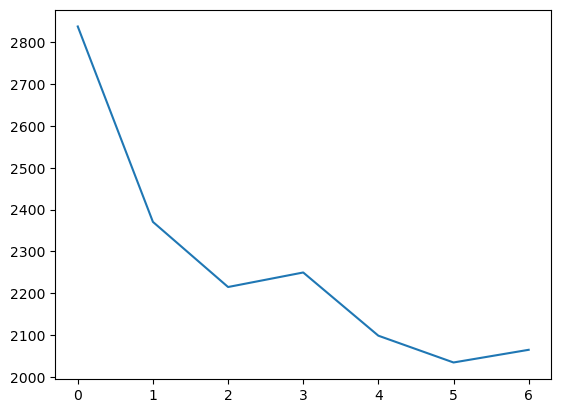

In [53]:
from matplotlib import pyplot as plt

epochs=7
learning_rate = .001
model = AttackNet().to(device)
criterion1 = torch.nn.MSELoss().to(device)
criterion2 = torch.nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(dataset=ds, batch_size=200, shuffle=True)

out=[]
for epoch in range(epochs):
    print("Epoch begin: ", epoch)
    cumulative_L = 0.
    for x,y in loader:

        x=x.to(device)
        y=y.to(device)
        # reset optimizer
        opt.zero_grad()

        decoded, output = model(x)
        loss1 = criterion1(decoded.to(device), x)
        loss2 = criterion2(output.to(device), y)
        loss = loss1+loss2
        
        loss.backward()
        opt.step()
        
        cumulative_L+=loss.item()
        
    out.append(cumulative_L)

plt.plot(out)

## Test

In [54]:
test_ds = NetMetrics(scaler.transform(testX), testY, dict_)
print(len(test_ds))
test_loader=DataLoader(test_ds, batch_size=1)

250000


In [55]:
model.to('cpu')

acc = [0]*2
translator={0 : 'ddos', 1 : 'Benign'}
model.eval()

with torch.no_grad():
    for inputs, ground_truth in test_loader:
        _,out=model(inputs)
        prediction = torch.argmax(out)
        if prediction == torch.argmax(ground_truth):
            acc[prediction]+=1
        #else:
            #print(prediction, torch.argmax(ground_truth))

acc

[123092, 121683]

In [56]:
val_count_test=testY.value_counts()
val_count_test

Benign    125053
ddos      124947
Name: Label, dtype: int64

In [57]:
acc_final=[a/val_count_test[translator[idx]] for idx,a in enumerate(acc)]
acc_final

[0.9851537051709925, 0.9730514261952932]

___